In [1]:
# coding=utf-8
import math

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [13]:
img = cv.imread(r'D:\MyCodes\pythonProject\coated_tongue_color\datas\category\1\43.png')

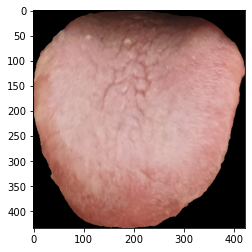

In [14]:
plt.imshow(img[:,:,::-1])

In [15]:
def gray_world(img):
    
    # 计算色度均值
    b, g, r = cv.split(img)
    averB = np.mean(b)
    averG = np.mean(g)
    averR = np.mean(r)
    gray_value = (averB + averG + averR)/3
    
    # 计算增益
    kb = gray_value/averB
    kg = gray_value/averG
    kr = gray_value/averR
    
    # 补偿通道增益
    b[:] = b[:] * kb
    g[:] = g[:] * kg
    r[:] = r[:] * kr 
    
    img = cv.merge([b, g, r])
    
    return img

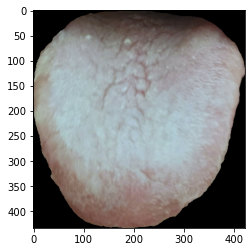

In [16]:
img_gray_world = gray_world(img)
plt.imshow(img_gray_world[:,:,::-1])

In [17]:
def zmMinFilterGray(src, r=7):
    """
    最小值滤波，r是滤波器半径
    """
    return cv.erode(src, np.ones((2 * r + 1, 2 * r + 1)))


def guidedfilter(I, p, r, eps):
    height, width = I.shape
    m_I = cv.boxFilter(I, -1, (r, r))
    m_p = cv.boxFilter(p, -1, (r, r))
    m_Ip = cv.boxFilter(I * p, -1, (r, r))
    cov_Ip = m_Ip - m_I * m_p

    m_II = cv.boxFilter(I * I, -1, (r, r))
    var_I = m_II - m_I * m_I

    a = cov_Ip / (var_I + eps)
    b = m_p - a * m_I

    m_a = cv.boxFilter(a, -1, (r, r))
    m_b = cv.boxFilter(b, -1, (r, r))
    return m_a * I + m_b


def Defog(m, r, eps, w, maxV1):                 # 输入rgb图像，值范围[0,1]
    '''计算大气遮罩图像V1和光照值A, V1 = 1-t/A'''
    V1 = np.min(m, 2)                           # 得到暗通道图像
    Dark_Channel = zmMinFilterGray(V1, 7)
    # cv.imshow('20190708_Dark',Dark_Channel)    # 查看暗通道
    # plt.imshow(Dark_Channel)

    V1 = guidedfilter(V1, Dark_Channel, r, eps)  # 使用引导滤波优化
    bins = 2000
    ht = np.histogram(V1, bins)                  # 计算大气光照A
    d = np.cumsum(ht[0]) / float(V1.size)
    for lmax in range(bins - 1, 0, -1):
        if d[lmax] <= 0.999:
            break
    A = np.mean(m, 2)[V1 >= ht[1][lmax]].max()
    V1 = np.minimum(V1 * w, maxV1)               # 对值范围进行限制
    return V1, A


def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):
    m = m / 255.0
    Y = np.zeros(m.shape)
    Mask_img, A = Defog(m, r, eps, w, maxV1)             # 得到遮罩图像和大气光照

    for k in range(3):
        Y[:,:,k] = (m[:,:,k] - Mask_img)/(1-Mask_img/A)  # 颜色校正
    Y = np.clip(Y, 0, 1)
    if bGamma:
        Y = Y ** (np.log(0.5) / np.log(Y.mean()))       # gamma校正,默认不进行该操作
    return Y

In [18]:
img_deHaze = deHaze(img_gray_world)

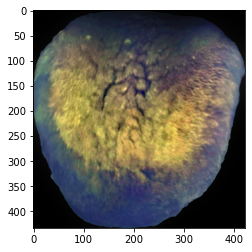

In [19]:
plt.imshow(img_deHaze)

In [283]:
def rayle_func(x, imax, imin, alpha=0.7):
    y = (x / alpha**2) * math.exp(-x**2/(alpha**2))
    # y = 255 *(x - imin) / ((imax-imin)*alpha**2) * math.exp(-(255*(x-imin))**2/(2*alpha**2))
    return y
    

def rayle_deal(img):
    imax = img.max()
    imin = img.min()
    for idx, x in np.ndenumerate(img):
        img[idx] = rayle_func(img[idx], imax, imin)
    return img


def rayleigh_stretch(img):
    im = img.astype(np.uint8)
    b, g, r = cv.split(img)
    averB = np.mean(b)
    averG = np.mean(g)
    averR = np.mean(r)
    total_value = averB + averG + averR
    
    rate_b = averB / total_value
    rate_g = averG / total_value
    rate_r = averR / total_value
    if rate_b >= 0.90:
        b[:] = b[:] * 0.90 / rate_b
    if rate_g >= 0.90:
        g[:] = g[:] * 0.90 / rate_g
    if rate_r <= 0.05:
        r[:] = r[:] * 0.05 / rate_r
        
    b = rayle_deal(b)
    g = rayle_deal(g)
    r = rayle_deal(r)
    
    img = cv.merge((b, g, r))
    
    return img

In [284]:
def hisEqulColor2(img):
    img = img.astype(np.uint8)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    channels = cv.split(hsv)
 
    # 以下代码详细注释见官网：
    # https://docs.opencv.org/4.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe.apply(channels[2], channels[2])
 
    cv.merge(channels, hsv)
    cv.cvtColor(hsv, cv.COLOR_HSV2RGB, img)
    return img

In [285]:
def equal_func(img):
    img = img.astype(np.uint8)
    b, g, r = cv.split(img) 
    eb = cv.equalizeHist(b)
    eg = cv.equalizeHist(g)
    er = cv.equalizeHist(r)
    equal_img = cv.merge((eb,eg,er)) 
    
    return equal_img

In [286]:
ray_img = rayleigh_stretch(img_deHaze)
# ray_img = rayleigh_stretch(ray_img)
# ray_img = rayleigh_stretch(ray_img)
# ray_img = gray_world(ray_img)

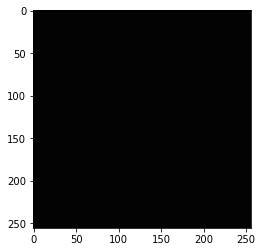

In [287]:
img2 = hisEqulColor2(img_deHaze)
plt.imshow(img2[:,:,::-1])

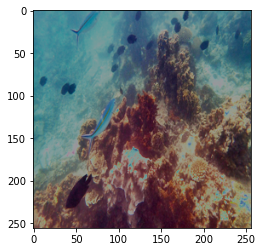

In [288]:
plt.imshow(ray_img[:,:,::-1])

In [289]:
def uciqe(img):
    img = img.astype(np.uint8)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)  # RGB转为HSV 
    H, S, V = cv.split(hsv)
    delta = np.std(H) /180  #色度的标准差 
    mu = np.mean(S) /255  #饱和度的平均值 
    n, m = np.shape(V)
    number = math.floor(n*m/100)  #所需像素的个数  
    Maxsum, Minsum = 0, 0
    V1, V2 = V /255, V/255

    for i in range(1, number+1):
        Maxvalue = np.amax(np.amax(V1))
        x, y = np.where(V1 == Maxvalue)
        Maxsum = Maxsum + V1[x[0],y[0]]
        V1[x[0],y[0]] = 0

    top = Maxsum/number

    for i in range(1, number+1):
        Minvalue = np.amin(np.amin(V2))
        X, Y = np.where(V2 == Minvalue)
        Minsum = Minsum + V2[X[0],Y[0]]
        V2[X[0],Y[0]] = 1

    bottom = Minsum/number

    conl = top-bottom
     ###对比度 
    uciqe = 0.4680*delta + 0.2745*conl + 0.2575*mu
    print(uciqe)
    return uciqe

In [361]:
uciqe(ray_img)

0.5843785823173345


0.5843785823173345

In [368]:
def uicm(img):
    b, r, g = cv.split(img)
    RG = r - g
    YB = (r + g)/2 - b
    m, n, o = np.shape(img)  #img为三维 rbg为二维 o并未用到
    K = m*n
    alpha_L = 0.1
    alpha_R = 0.1 #参数α 可调
    T_alpha_L = math.ceil(alpha_L*K)  #向上取整 #表示去除区间
    T_alpha_R = math.floor(alpha_R*K) #向下取整

    RG_list = RG.flatten() #二维数组转一维（方便计算）
    RG_list = sorted(RG_list)  #排序
    sum_RG = 0 #计算平均值
    for i in range(T_alpha_L+1, K-T_alpha_R ): 
        sum_RG = sum_RG + RG_list[i]
    U_RG = sum_RG/(K - T_alpha_R - T_alpha_L)
    squ_RG = 0 #计算方差
    for i in range(K):
        squ_RG = squ_RG + np.square(RG_list[i] - U_RG)
    sigma2_RG = squ_RG/K

    #YB和RG计算一样
    YB_list = YB.flatten()
    YB_list = sorted(YB_list)
    sum_YB = 0
    for i in range(T_alpha_L+1, K-T_alpha_R ):
        sum_YB = sum_YB + YB_list[i]
    U_YB = sum_YB/(K - T_alpha_R - T_alpha_L)
    squ_YB = 0
    for i in range(K):
        squ_YB = squ_YB + np.square(YB_list[i] - U_YB)
    sigma2_YB = squ_YB/K

    uicm = -0.0268*np.sqrt(np.square(U_RG) + np.square(U_YB)) + 0.1586*np.sqrt(sigma2_RG + sigma2_YB)
    print(uicm)

In [369]:
uicm(img)

15.972612957960969


In [375]:
def EME(img, L=5):
    m, n = np.shape(img)  #横向为n列 纵向为m行
    number_m = math.floor(m/L)
    number_n = math.floor(n/L)
    #A1 = np.zeros((L, L)) #创建一个L*L的全0数组用于存放 #用不用没有差别
    m1 = 0
    E = 0
    for i in range(number_m): #将图片按照L*L分成小块 其余的部分舍去
        n1 = 0
        for t in range(number_n):
            A1 = img[m1:m1+L, n1:n1+L]
            img_min = np.amin(np.amin(A1))
            img_max = np.amax(np.amax(A1))

            if img_min > 0 :
                img_ratio = img_max/img_min
            else :
                img_ratio = img_max  ###
            E = E + np.log(img_ratio + 1e-5)

            n1 = n1 + L
        m1 = m1 + L
    E_sum = 2*E/(number_m*number_n)
    return E_sum

In [376]:
b, g, r = cv.split(ray_img)
be = EME(b) + EME(g) + EME(r)

In [377]:
be

4.59576558999462